In [1]:
import mne
import numpy as np
import pandas as pd
from pathlib import Path
from mne.decoding import Vectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

### Read MEG data and metadata

In [2]:
ROOT = Path.cwd()                     # .../MEG/Data Analysis
MEG_ROOT = ROOT.parent                # .../MEG

LOCALIZER_EPO = (
    MEG_ROOT / "Data" / "Pilot" / "BIDS" / "derivatives" /
    "mne-bids-pipeline" / "sub-01" / "meg" / "sub-01_task-localizer_epo.fif"
)

epochs = mne.read_epochs(LOCALIZER_EPO)

# Read labels
df = pd.read_csv("metadata.csv")

print(df.head())

Reading /Users/Barbu/Documents/Postdoc/Experiments/Pushmi/MEG/Data/Pilot/BIDS/derivatives/mne-bids-pipeline/sub-01/meg/sub-01_task-localizer_epo.fif ...
    Found the data of interest:
        t =    -200.00 ...    1000.00 ms
        0 CTF compensation matrices available
Adding metadata with 3 columns
960 matching events found
No baseline correction applied
0 projection items activated
   subject_id       task  trial_block  trial_number stimulus_type meaning  \
0           1  localizer            1             1          word   carre   
1           1  localizer            1             2         image   croix   
2           1  localizer            1             3          word   dinde   
3           1  localizer            1             4         image   biche   
4           1  localizer            1             5          word  cercle   

  meaning_superordinate     stimulus participant_response  reaction_time  \
0                 shape   word_carre                  NaN            NaN

### Set X (data) and y (labels) for the model

In [52]:
X = epochs.pick_types(meg='mag').get_data()
n_trials, n_channels, n_times = X.shape

y = df["stimulus"].values

labels = ['image_carre', 'word_carre',
          'image_losange', 'word_losange',
          'image_croix', 'word_croix',
          'image_cercle', 'word_cercle',
          'image_biche', 'word_biche',
          'image_dinde', 'word_dinde',
          'image_lampe', 'word_lampe',
          'image_pince', 'word_pince']

labels = ['image_carre', 'image_losange', 'image_croix', 'image_cercle', 
          'image_biche', 'image_dinde', 
          'image_lampe','image_pince', 
          'word_carre', 'word_losange', 'word_croix', 'word_cercle',
          'word_biche', 'word_dinde',
          'word_lampe', 'word_pince'
          ]

d = {k:v for v, k in enumerate(labels)}

# Encode class labels to stable integer indices (ensures consistent column order across folds)
y_enc = np.array([d[s] for s in y])

NUM_CLASSES = df["stimulus"].nunique()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


### Define classifiers

In [8]:
# Define pipeline: standardize features within folds, then linear classifier
base_clf = LogisticRegression(solver="liblinear", max_iter=1000) #SVC(C=1, kernel='linear', decision_function_shape='ovo', probability = True) 

pipeline = make_pipeline(
    StandardScaler(with_mean=True, with_std=True), 
    Vectorizer(),
    base_clf
    )

# One-vs-One wrapper around the whole pipeline
ovo_clf = OneVsOneClassifier(pipeline)

### Train model at each time point

In [75]:
# CV split
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store confusion matrices per timepoint
cm_time = np.zeros((n_times, NUM_CLASSES, NUM_CLASSES))

for ti in range(n_times):
    # Features at this timepoint: (n_trials, n_channels)
    X_t = X[:, :, ti]

    # Decision function scores
    y_scores = cross_val_predict(ovo_clf, X_t, y_enc, cv=cv,
                                 method="decision_function", n_jobs=1)

    y_pred_idx = np.argmax(y_scores, axis=1)

    # Confusion matrix at this timepoint
    cm = confusion_matrix(y_enc, y_pred_idx, labels=np.arange(NUM_CLASSES))
    cm_norm = cm / cm.sum(axis=1, keepdims=True)
    cm_time[ti] = cm_norm

Saved video to: confusion_over_time_ovo.mp4


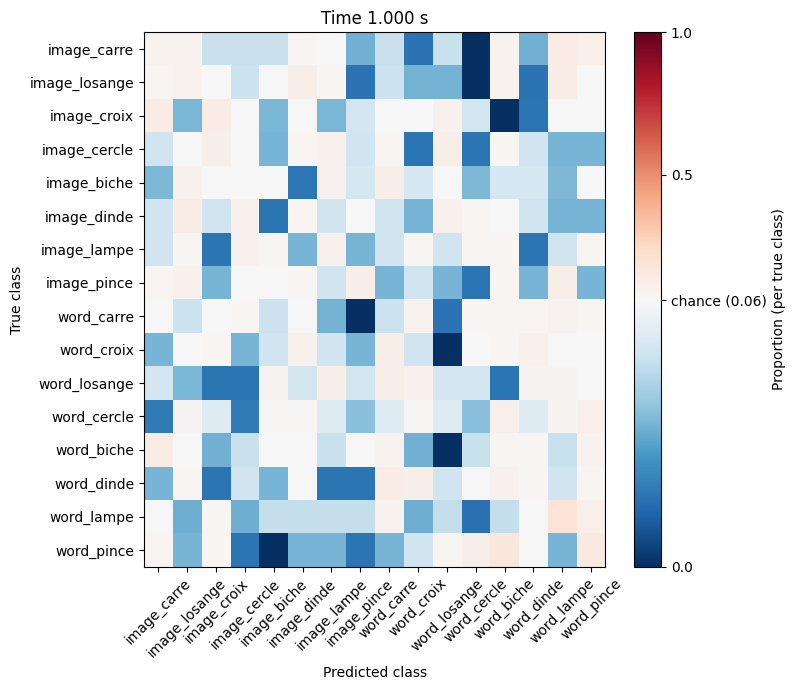

In [ ]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
from matplotlib.colors import TwoSlopeNorm

times = epochs.times
chance = 1 / NUM_CLASSES
OUT_VIDEO = Path("confusion_over_time_ovo.mp4")

# Define a diverging colormap centered at chance
fig_cm, ax_cm = plt.subplots(figsize=(8, 7))
norm = TwoSlopeNorm(vmin=0.0, vcenter=chance, vmax=1.0)
im = ax_cm.imshow(cm_time[0], norm=norm, cmap="RdBu_r",
                  origin='upper', interpolation='nearest', aspect='auto')

# Colorbar with explicit ticks
cbar = plt.colorbar(im, ax=ax_cm)
cbar.set_label("Proportion (per true class)")
cbar.set_ticks([0.0, chance, 0.5, 1.0])
cbar.set_ticklabels([0.0, f"chance ({chance:.2f})", 0.5, 1.0])
ax_cm.set_title(f"Time {times[0]:.3f} s")
ax_cm.set_xlabel("Predicted class")
ax_cm.set_ylabel("True class")
ax_cm.set_title(f"Time {times[0]:.3f} s")
ax_cm.set_xticks(np.arange(NUM_CLASSES))
ax_cm.set_yticks(np.arange(NUM_CLASSES))
ax_cm.set_xticklabels(labels, rotation = 45)
ax_cm.set_yticklabels(labels)
plt.tight_layout()

def update(frame_idx):
    im.set_data(cm_time[frame_idx])
    ax_cm.set_title(f"Time {times[frame_idx]:.3f} s")
    return (im,)

anim = FuncAnimation(fig_cm, update, frames=n_times, interval=100, blit=True)

writer = FFMpegWriter(fps=30)
anim.save(str(OUT_VIDEO), writer=writer)
print(f"Saved video to: {OUT_VIDEO}")

In [ ]:
def generate_cross_modal_matrix(confusion, timepoint, labels, plot = False):
    cm_timepoint = confusion[timepoint]
    
    image_idx = [i for i, name in enumerate(labels) if name.startswith("image")]
    word_idx  = [i for i, name in enumerate(labels) if name.startswith("word")]
    
    im_labels = labels[:max(image_idx) + 1]
    wd_labels = labels[min(word_idx):max(word_idx) + 1]
    
    # Extract the image-word block
    im_wd = cm_timepoint[np.ix_(image_idx, word_idx)]
    
    return im_wd, im_labels, wd_labels
    
mat, im_labels, wd_labels = generate_cross_modal_matrix(cm_time, 0, labels, plot = False)

In [ ]:
cm_semantic = np.zeros((n_times, 8, 8))

for ti in range(n_times):
    mat, im_labels, wd_labels = generate_cross_modal_matrix(cm_time, ti, labels, plot = False)
    cm_semantic[ti] = mat

Saved video to: images_to_words.mp4


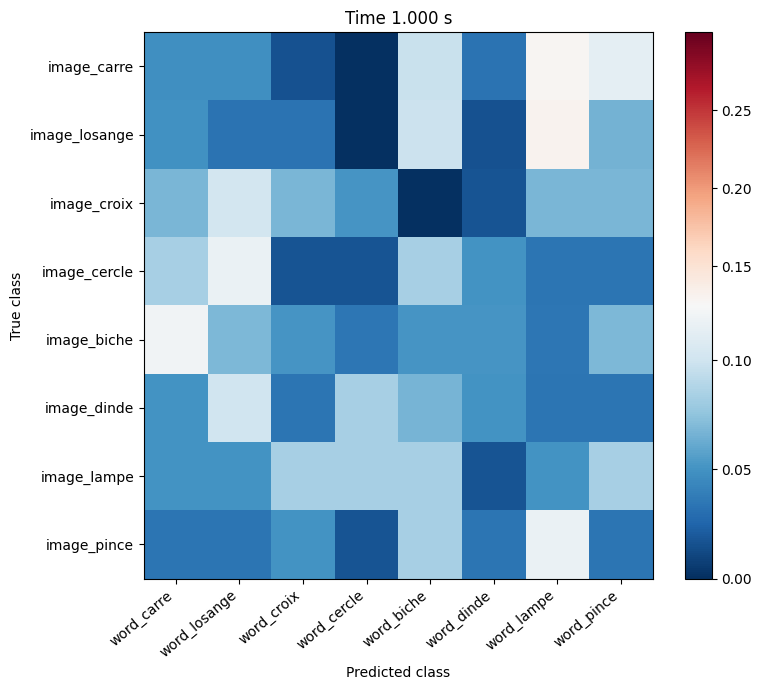

In [106]:
OUT_VIDEO = Path("images_to_words.mp4")

chance = 1 / 8
times = epochs.times

fig_cm, ax_cm = plt.subplots(figsize=(8, 7))
norm = TwoSlopeNorm(vmin=0.0, vcenter=chance, vmax=0.3)
im = ax_cm.imshow(cm_semantic[0], norm=norm, cmap="RdBu_r",
                  origin='upper', interpolation='nearest', aspect='auto')

ax_cm.set_yticks(range(8))
ax_cm.set_yticklabels(im_labels)
ax_cm.set_xticks(range(8))
ax_cm.set_xticklabels(wd_labels, rotation=40, ha="right")
ax_cm.set_xlabel("Predicted class")
ax_cm.set_ylabel("True class")
ax_cm.set_title(f"Time {times[0]:.3f} s")
plt.tight_layout()
plt.colorbar(im, ax=ax_cm)

def update(frame_idx):
    im.set_data(cm_semantic[frame_idx])
    ax_cm.set_title(f"Time {times[frame_idx]:.3f} s")
    return (im,)

anim = FuncAnimation(fig_cm, update, frames=n_times, interval=100, blit=True)

writer = FFMpegWriter(fps=30)
anim.save(str(OUT_VIDEO), writer=writer)
print(f"Saved video to: {OUT_VIDEO}")
